Sensitivity study- using different layers than fc1
====
Note that different layers have very different size outputs- cannot only change one setting at a time. Come back to this.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

import sys
sys.path.insert(0,'../')
import NEU_utils

In [2]:
### list of accuracies for final boxplot
features_all = [] # list of feature names
accs_all = [] # list of list of all accuracies for each feature 
inertias_all = [] # list of points corresponding to accuracy of clustering with minimum inertia for each feature

fc2 features
===

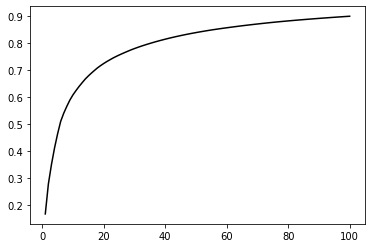

In [3]:
layer = 'fc2'
with open('../vgg16_data/{}_features.pickle'.format(layer),
          'rb') as f:
    data = pickle.load(f)

files = data['filename']

layer_name = data['layer_name']
features = data[layer_name]
shape = features.shape
features = np.reshape(features, newshape=(shape[0], np.prod(shape[1:])))

labels = [x[:2] for x in files]
y_true = [NEU_utils.label_mapper[x] for x in labels]


pca = PCA(n_components=25, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=25, svd_solver='full', whiten=False)


pca_n = PCA(svd_solver='full', whiten='False')
pca_n.fit(features)

var = pca_n.explained_variance_ratio_.cumsum()[:100]

plt.plot(range(1, len(var)+1), var, '-k')

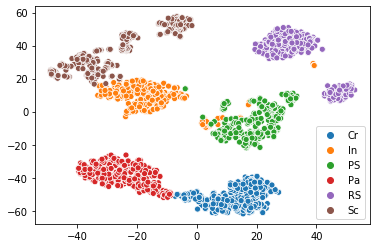

In [4]:
x_nw = pca_nw.fit_transform(features)
x = pca.fit_transform(features)



tsne = TSNE(n_components=2, random_state=12213)
x_tsne = tsne.fit_transform(x_nw)
fig, ax = plt.subplots()
sns.scatterplot(x_tsne[:,0], x_tsne[:,1], hue=labels)
plt.show()

max acc: 0.972
min inertia:0.969


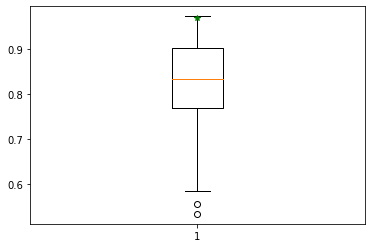

In [5]:
n = 500
accs = np.zeros(n)
inertias = np.zeros(n)

for i in range(n):
    kmeans = KMeans(n_clusters=7, init='k-means++', 
                    n_init=1, random_state=22546+i)
    kmeans.fit(x)
    labels_unmatched = kmeans.labels_
    y_pred = NEU_utils.file_matcher(labels_unmatched, 
        labels, NEU_utils.label_mapper)
    CM = confusion_matrix(y_true, y_pred)
    acc = CM.trace()/CM.sum()
    accs[i] = acc
    inertias[i] = kmeans.inertia_

features_all.append('fc2')
accs_all.append(accs)
inertias_all.append(accs[inertias.argmin()])

data = plt.boxplot(accs)
plt.plot([1],[accs[inertias.argmin()]], '*g')
print('max acc: {:.3f}\nmin inertia:{:.3f}'.format(accs.max(), 
                                                   accs[inertias.argmin()]))
    

block5_pool features
===

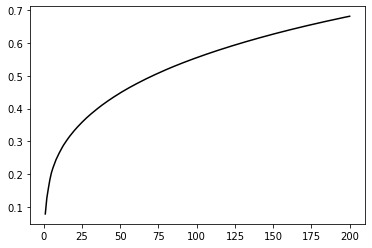

In [6]:
layer = 'block5_pool'
with open('../vgg16_data/{}_features.pickle'.format(layer),
          'rb') as f:
    data = pickle.load(f)

files = data['filename']

layer_name = data['layer_name']
features = data[layer_name]
shape = features.shape
features = np.reshape(features, newshape=(shape[0], np.prod(shape[1:])))

labels = [x[:2] for x in files]
y_true = [NEU_utils.label_mapper[x] for x in labels]

nc = 35
pca = PCA(n_components=nc, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=nc, svd_solver='full', whiten=False)


pca_n = PCA(svd_solver='full', whiten='False')
pca_n.fit(features)

var = pca_n.explained_variance_ratio_.cumsum()[:200]

plt.plot(range(1, len(var)+1), var, '-k')

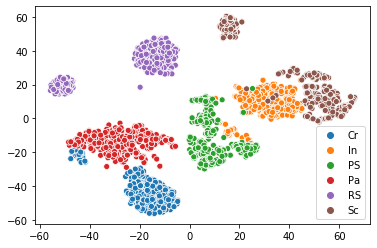

In [7]:
x_nw = pca_nw.fit_transform(features)
x = pca.fit_transform(features)



tsne = TSNE(n_components=2, random_state=12213)
x_tsne = tsne.fit_transform(x_nw)
fig, ax = plt.subplots()
sns.scatterplot(x_tsne[:,0], x_tsne[:,1], hue=labels)
plt.show()

max acc: 0.906
min inertia:0.893


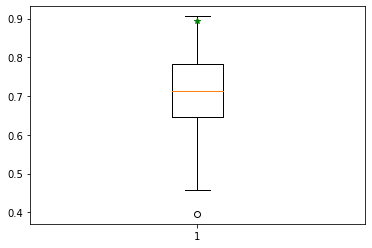

In [8]:
n = 500
accs = np.zeros(n)
inertias = np.zeros(n)

for i in range(n):
    kmeans = KMeans(n_clusters=7, init='k-means++', 
                    n_init=1, random_state=22546+i)
    kmeans.fit(x)
    labels_unmatched = kmeans.labels_
    y_pred = NEU_utils.file_matcher(labels_unmatched, 
        labels, NEU_utils.label_mapper)
    CM = confusion_matrix(y_true, y_pred)
    acc = CM.trace()/CM.sum()
    accs[i] = acc
    inertias[i] = kmeans.inertia_

features_all.append('block5_pool')
accs_all.append(accs)
inertias_all.append(accs[inertias.argmin()])

data = plt.boxplot(accs)
plt.plot([1],[accs[inertias.argmin()]], '*g')
print('max acc: {:.3f}\nmin inertia:{:.3f}'.format(accs.max(), 
                                                   accs[inertias.argmin()]))
    

block4_pool features
===

In [10]:
# layer = 'block4_pool'
# with open('../vgg16_data/{}_features.pickle'.format(layer),
#           'rb') as f:
#     data = pickle.load(f)

# files = data['filename']

# layer_name = data['layer_name']
# features = data[layer_name]
# shape = features.shape
# features = np.reshape(features, newshape=(shape[0], np.prod(shape[1:])))

# labels = [x[:2] for x in files]
# y_true = [NEU_utils.label_mapper[x] for x in labels]

# nc = 50
# pca = PCA(n_components=nc, svd_solver='full', whiten=True)
# pca_nw = PCA(n_components=nc, svd_solver='full', whiten=False)


# pca_n = PCA(svd_solver='full', whiten='False')
# pca_n.fit(features)

# var = pca_n.explained_variance_ratio_.cumsum()[:200]

# plt.plot(range(1, len(var)+1), var, '-k')

In [ ]:
# x_nw = pca_nw.fit_transform(features)
# x = pca.fit_transform(features)



# tsne = TSNE(n_components=2, random_state=12213)
# x_tsne = tsne.fit_transform(x_nw)
# fig, ax = plt.subplots()
# sns.scatterplot(x_tsne[:,0], x_tsne[:,1], hue=labels)
# plt.show()

In [ ]:
# n = 500
# accs = np.zeros(n)
# inertias = np.zeros(n)

# for i in range(n):
#     kmeans = KMeans(n_clusters=7, init='k-means++', 
#                     n_init=1, random_state=22546+i)
#     kmeans.fit(x)
#     labels_unmatched = kmeans.labels_
#     y_pred = NEU_utils.file_matcher(labels_unmatched, 
#         labels, NEU_utils.label_mapper)
#     CM = confusion_matrix(y_true, y_pred)
#     acc = CM.trace()/CM.sum()
#     accs[i] = acc
#     inertias[i] = kmeans.inertia_



# features_all.append('block4_pool')
# accs_all.append(accs)
# inertias_all.append(accs[inertias.argmin()])

# data = plt.boxplot(accs)
# plt.plot([1],[accs[inertias.argmin()]], '*g')
# print('max acc: {:.3f}\nmin inertia:{:.3f}'.format(accs.max(), 
#                                                    accs[inertias.argmin()]))
    

block5 conv3 features
===

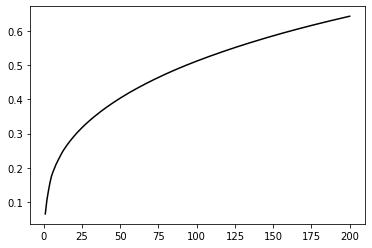

In [11]:
layer = 'block5_conv3'
with open('../vgg16_data/{}_features.pickle'.format(layer),
          'rb') as f:
    data = pickle.load(f)

files = data['filename']

layer_name = data['layer_name']
features = data[layer_name]
shape = features.shape
features = np.reshape(features, newshape=(shape[0], np.prod(shape[1:])))

labels = [x[:2] for x in files]
y_true = [NEU_utils.label_mapper[x] for x in labels]

nc = 35
pca = PCA(n_components=nc, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=nc, svd_solver='full', whiten=False)


pca_n = PCA(svd_solver='full', whiten='False')
pca_n.fit(features)

var = pca_n.explained_variance_ratio_.cumsum()[:200]

plt.plot(range(1, len(var)+1), var, '-k')

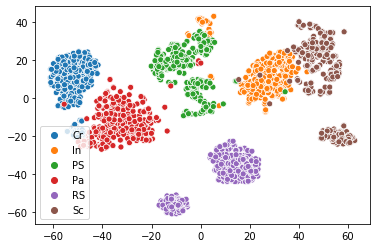

In [12]:
x_nw = pca_nw.fit_transform(features)
x = pca.fit_transform(features)



tsne = TSNE(n_components=2, random_state=12213)
x_tsne = tsne.fit_transform(x_nw)
fig, ax = plt.subplots()
sns.scatterplot(x_tsne[:,0], x_tsne[:,1], hue=labels)
plt.show()

max acc: 0.905
min inertia:0.904


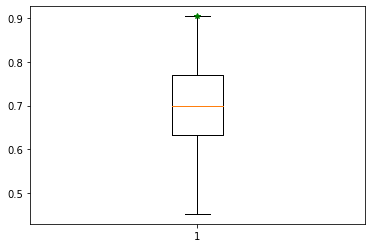

In [13]:
n = 500
accs = np.zeros(n)
inertias = np.zeros(n)

for i in range(n):
    kmeans = KMeans(n_clusters=7, init='k-means++', 
                    n_init=1, random_state=22546+i)
    kmeans.fit(x)
    labels_unmatched = kmeans.labels_
    y_pred = NEU_utils.file_matcher(labels_unmatched, 
        labels, NEU_utils.label_mapper)
    CM = confusion_matrix(y_true, y_pred)
    acc = CM.trace()/CM.sum()
    accs[i] = acc
    inertias[i] = kmeans.inertia_

features_all.append('block5_conv3')
accs_all.append(accs)
inertias_all.append(accs[inertias.argmin()])



data = plt.boxplot(accs)
plt.plot([1],[accs[inertias.argmin()]], '*g')
print('max acc: {:.3f}\nmin inertia:{:.3f}'.format(accs.max(), 
                                                   accs[inertias.argmin()]))


final plot
----
todo add fc1, block4 conv3, order boxplot by depth in network

[Text(0, 0, 'fc2'), Text(0, 0, 'block5\npool'), Text(0, 0, 'block5\nconv3')]

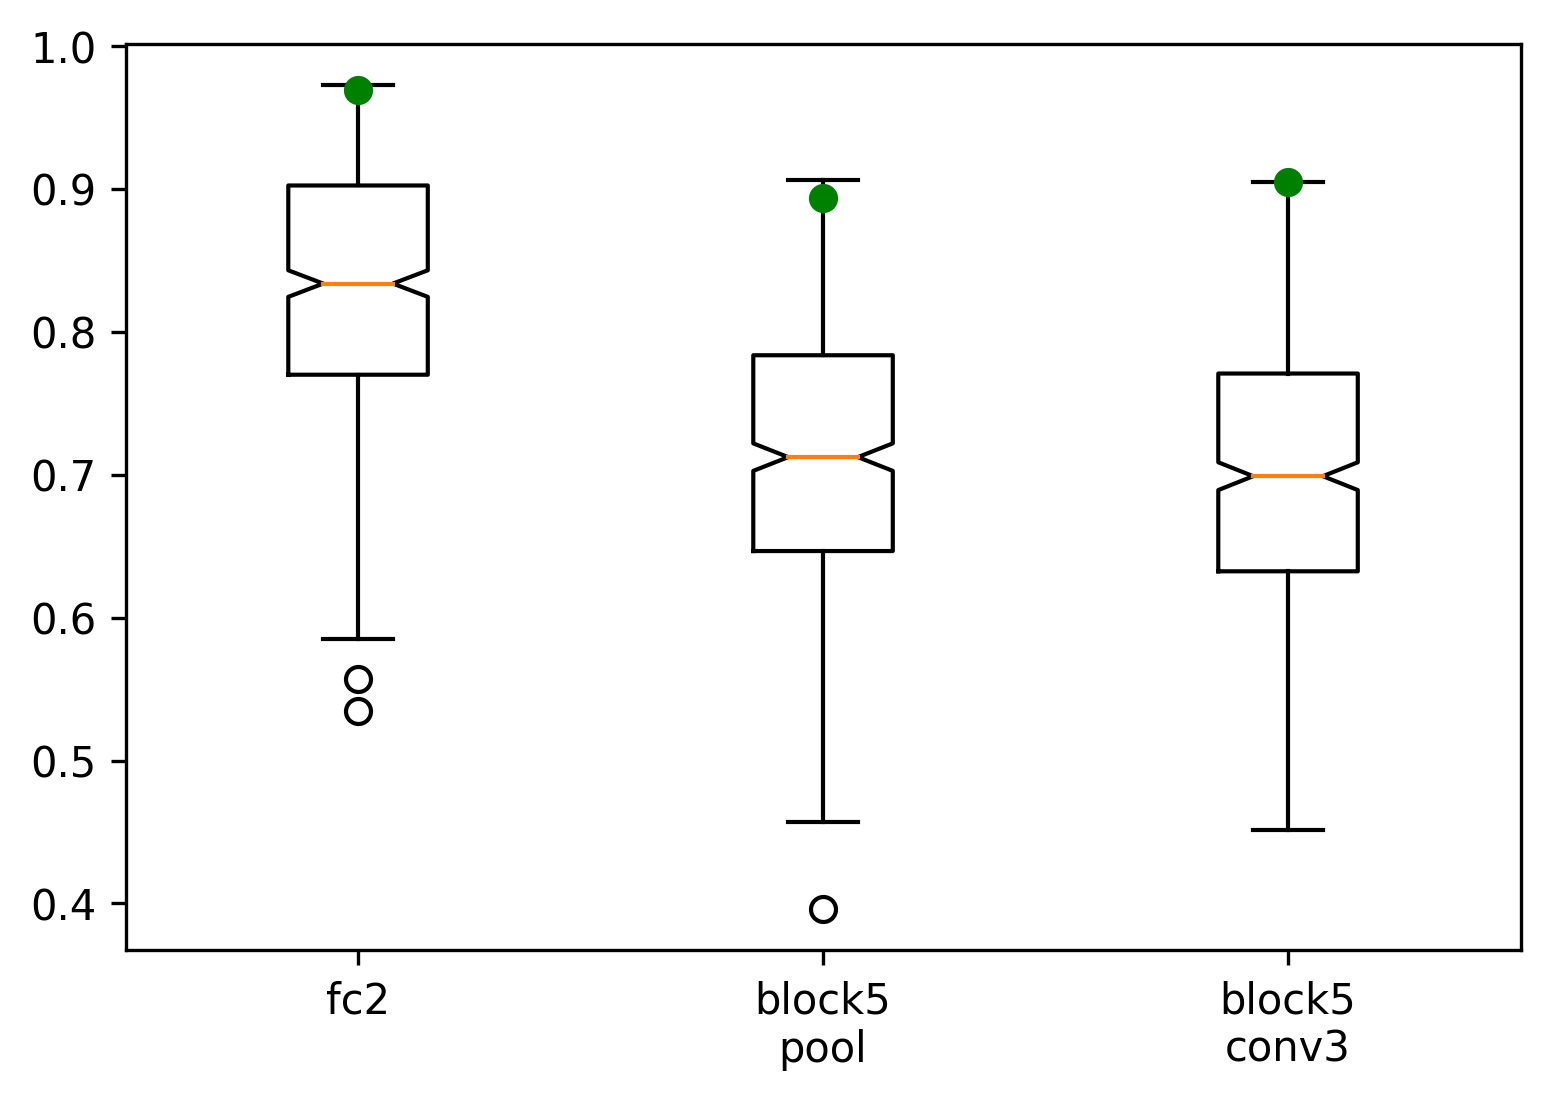

In [24]:
fig, ax = plt.subplots(dpi=300)

ax.boxplot(accs_all, notch=True)
ax.plot([1,2,3], inertias_all, 'go')
ax.xaxis.set_ticklabels([x.replace('_','\n') for x in features_all], rotation=0)
